# Chapter 10. Prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# !pip install --upgrade yfinance
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
import itertools

In [2]:
# https://facebook.github.io/prophet/docs/installation.html#python
# Import FB Prophet libraries
# !pip install --upgrade prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_forecast_component

## Import DataSets from Internet (Chapter 06)

### Get Data from Internet

In [3]:
is_internet_data = True
if is_internet_data: # Make True to Get data from the Internet
  # Top Assets of NASDAQ stock exchange
  nasdaq_tickers = [
      'MRNA',  # Moderna, Inc.
      'DLTR',  # Dollar Tree, Inc.
    # 'CEG',   # Constellation Energy Corporation (started from 2022-01-19)
      'ZS',    # Zscaler, Inc.
      'MCHP',  # Microchip Technology Incorporated
      'SBUX',  # Starbucks Corporation
      'HON',   # Honeywell International Inc.
      'JD',    # JD.com, Inc.
      'DDOG',  # Datadog, Inc.
      'AMAT',  # Applied Materials, Inc.
      'AAPL',  # Apple Inc.
      'AMGN',  # Amgen Inc.
      'INTU',  # Intuit Inc.
      'PCAR',  # PACCAR Inc
      'MDLZ',  # Mondelez International, Inc.
      'CSGP',  # CoStar Group, Inc.
      'FTNT',  # Fortinet, Inc.
      'KDP',   # Keurig Dr Pepper Inc.
      'META',  # Meta Platforms, Inc.
      'VRSK',  # Verisk Analytics, Inc.
      'MAR',   # Marriott International, Inc.
      'MRVL',  # Marvell Technology, Inc.
      'AZN',   # AstraZeneca PLC
      'ILMN',  # Illumina, Inc.
      'ENPH',  # Enphase Energy, Inc.
      'SIRI',  # Sirius XM Holdings Inc.
      'MELI',  # MercadoLibre, Inc.
      'ZM',    # Zoom Video Communications, Inc.
      'TSLA',  # Tesla, Inc.
      'BKR',   # Baker Hughes Company
      'URBN'   # Urban Outfitters, Inc.
  ]

  start='2021-01-01'
  end='2023-10-01'

  # Download stock data
  df = yf.download(tickers=nasdaq_tickers,
                  start=start, end=end,
                  actions=True)
  df = df.sort_index()

  # Creating a Multi-Level Column Structure for 'RoR'
  pct_change = df['Adj Close'].pct_change()
  logRoR = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
  pct_change.columns = pd.MultiIndex.from_product([['RoR'],
                                                  pct_change.columns])
  logRoR.columns = pd.MultiIndex.from_product([['logRoR'],
                                                  logRoR.columns])
  # Concatenating the new 'RoR' DataFrame with the original DataFrame
  df = pd.concat([df, pct_change], axis=1)
  df = pd.concat([df, logRoR], axis=1)
  df.dropna(inplace=True)
  # Displaying the updated DataFrame
  print(df.head())
  # Save data files
  df.to_csv('nasdaq_assets.csv')

  # Ticker symbol for NASDAQ-100 index
  index_ticker = '^NDX'  # This is a common symbol used for the NASDAQ-100 index

  # Downloading historical data for the index
  index_data = yf.download(index_ticker,
                          start=start,
                          end=end)
  index_data['RoR'] = index_data['Adj Close'].pct_change()
  index_data['logRoR'] = np.log(index_data['Adj Close'] / index_data['Adj Close'].shift(1))
  index_data.dropna(inplace=True)
  print(index_data.head())
  index_data.to_csv('nasdaq_index.csv')

[*********************100%%**********************]  30 of 30 completed


             Adj Close                                               \
Ticker            AAPL       AMAT        AMGN        AZN        BKR   
Date                                                                  
2021-01-05  128.572327  87.034195  203.932800  46.486183  19.333618   
2021-01-06  124.244385  88.228989  208.848480  46.678738  20.152071   
2021-01-07  128.484009  91.852165  209.537918  46.018581  20.615856   
2021-01-08  129.592957  92.823547  213.540283  46.632889  20.433981   
2021-01-11  126.580093  95.154816  212.716522  46.357830  20.597670   

                                                                      ...  \
Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...   
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000 

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2021-01-05  12663.129883  12809.669922  12663.129883  12802.379883   
2021-01-06  12601.259766  12803.290039  12569.419922  12623.349609   
2021-01-07  12745.410156  12966.679688  12744.820312  12939.570312   
2021-01-08  13037.240234  13113.089844  12939.730469  13105.200195   
2021-01-11  12961.500000  13023.209961  12883.589844  12902.490234   

               Adj Close      Volume       RoR    logRoR  
Date                                                      
2021-01-05  12802.379883  6971860000  0.008485  0.008450  
2021-01-06  12623.349609  7689880000 -0.013984 -0.014083  
2021-01-07  12939.570312  6841480000  0.025050  0.024742  
2021-01-08  13105.200195  7289390000  0.012800  0.012719  
2021-01-11  12902.490234  6960470000 -0.015468 -0.015589  


### Load data from the local files

In [4]:
nasdaq_assets = pd.read_csv('nasdaq_assets.csv',
                           index_col = 0,
                           parse_dates=[0],
                           header = [0, 1])
nasdaq_assets_ac = nasdaq_assets['Adj Close']
print(nasdaq_assets_ac.head())

nasdaq_index = pd.read_csv('nasdaq_index.csv',
                          index_col=0,
                          parse_dates=['Date'])
nasdaq_index_ac = nasdaq_index['Adj Close']
nasdaq_index_pc = nasdaq_index['RoR']
print(nasdaq_index_ac.head())

Ticker            AAPL       AMAT        AMGN        AZN        BKR  \
Date                                                                  
2021-01-05  128.572327  87.034195  203.932800  46.486183  19.333618   
2021-01-06  124.244385  88.228989  208.848480  46.678738  20.152071   
2021-01-07  128.484009  91.852165  209.537918  46.018581  20.615856   
2021-01-08  129.592957  92.823547  213.540283  46.632889  20.433981   
2021-01-11  126.580093  95.154816  212.716522  46.357830  20.597670   

Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...  \
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000  213.759995  28.650000  ...   
2021-01-08  91.952003   99.940002  112.970001  207.410004  29.628000  ...   
2021-01-11  90.436996  104.250000  112.4

## Prophet for Simple Time Series Analysis

In [5]:
# Suppress DEBUG and INFO messages specifically for the 'prophet' and 'cmdstanpy' loggers
import logging
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [6]:
# nasdaq_index has information about NASDAQ index dynamics
# Creating a DataFrame
df = pd.DataFrame({
    'ds': nasdaq_index.index,
    'y': nasdaq_index['Adj Close']
})
# Initialize the Prophet model
m = Prophet()
# Fit the model
m.fit(df)
# Make predictions
forecast = m.predict(df[['ds']])
# Plot the forecast using Plotly for an interactive plot.
plot_plotly(m, forecast)

08:04:22 - cmdstanpy - INFO - Chain [1] start processing
08:04:22 - cmdstanpy - INFO - Chain [1] done processing


/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



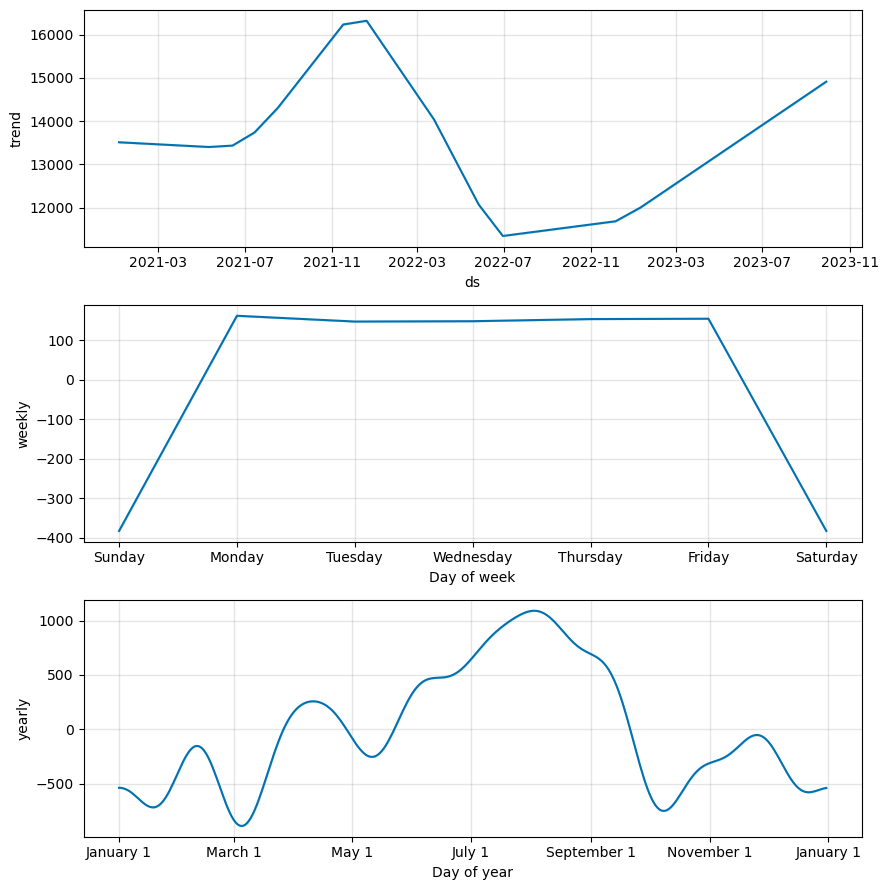

In [7]:
# Default seasonality components visualization
fig2 = m.plot_components(forecast)

In [8]:
# Actual values
y_true = df['y']

# Forecasted values
y_pred = forecast['yhat']

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"MAPE: {mape}")

MAPE: 2.082619671006361


### Prophet's Predictions

### Seasonality Parameters

08:04:22 - cmdstanpy - INFO - Chain [1] start processing
08:04:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

08:04:22 - cmdstanpy - INFO - Chain [1] start processing
08:04:23 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of Datetim

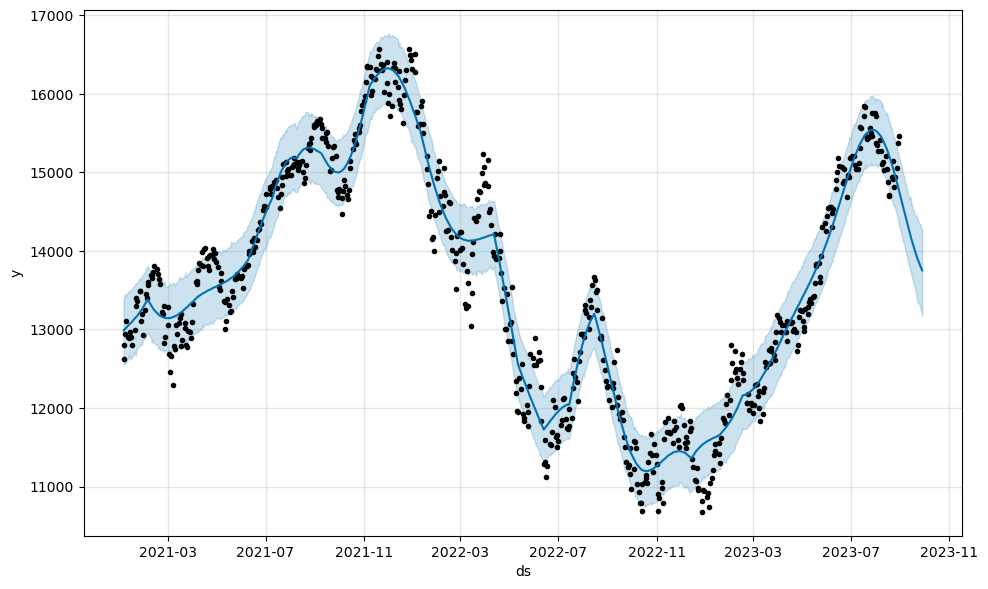

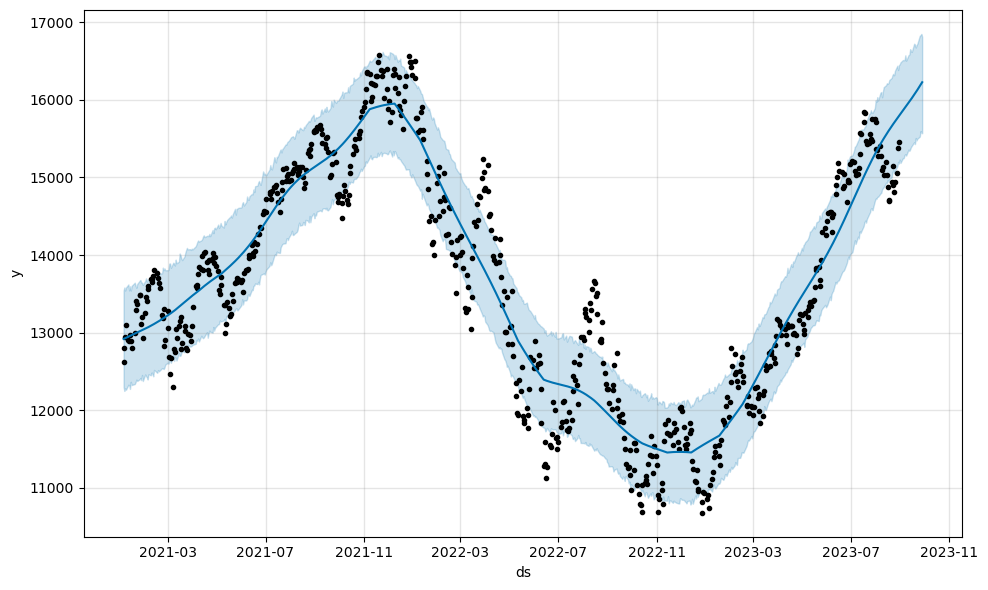

In [9]:
test_period = 21
df_train = df[:-test_period]
df_test = df[-test_period:]
# Initialize and Fit the Prophet model with
# custom seasonality settings (Model 1)
m = Prophet(
    seasonality_mode='multiplicative', 
    daily_seasonality=False,  
    weekly_seasonality=True, 
    yearly_seasonality=4,  
    seasonality_prior_scale=10.0
).fit(df_train)
# Generate a DataFrame for future predictions 
# covering 21 business days
future = m.make_future_dataframe(periods=21, 
                                 freq='B')
# Predict future values and plot the forecast
forecast = m.predict(future)
# Plot the forecast
fig1 = m.plot(forecast)  
# Re-initialize the Prophet model 
# with increased regularization
# for seasonality (Model 2)
m2 = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=4,
    seasonality_prior_scale=0.001
).fit(df_train)
# Make new predictions and plot the forecast 
# with increased regularization
forecast2 = m2.predict(future)
# Plot the new forecast
fig2 = m2.plot(forecast2)  

08:04:23 - cmdstanpy - INFO - Chain [1] start processing
08:04:23 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetim

                                            687                  688
ds                          2023-09-27 00:00:00  2023-09-28 00:00:00
trend                               1554.122424          1554.946189
yhat_lower                         13792.946106         13776.521832
yhat_upper                         14942.693067         14921.821765
trend_lower                         1514.246716          1509.218926
trend_upper                         1602.460107          1608.017239
monthly                               -0.000036            -0.008095
monthly_lower                         -0.000036            -0.008095
monthly_upper                         -0.000036            -0.008095
multiplicative_terms                   8.234536             8.223822
multiplicative_terms_lower             8.234536             8.223822
multiplicative_terms_upper             8.234536             8.223822
weekly                                 8.504052             8.506063
weekly_lower                      

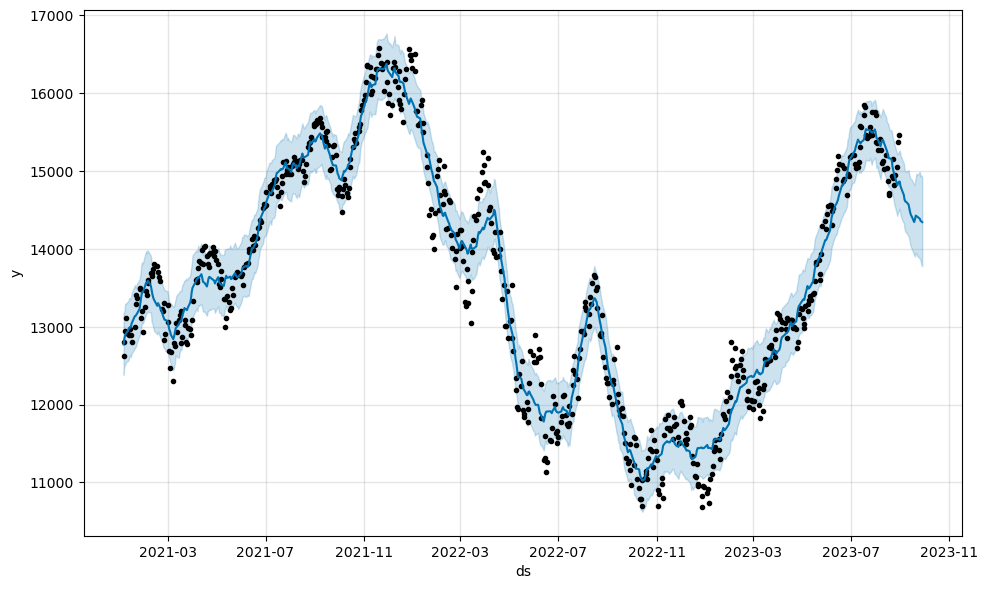

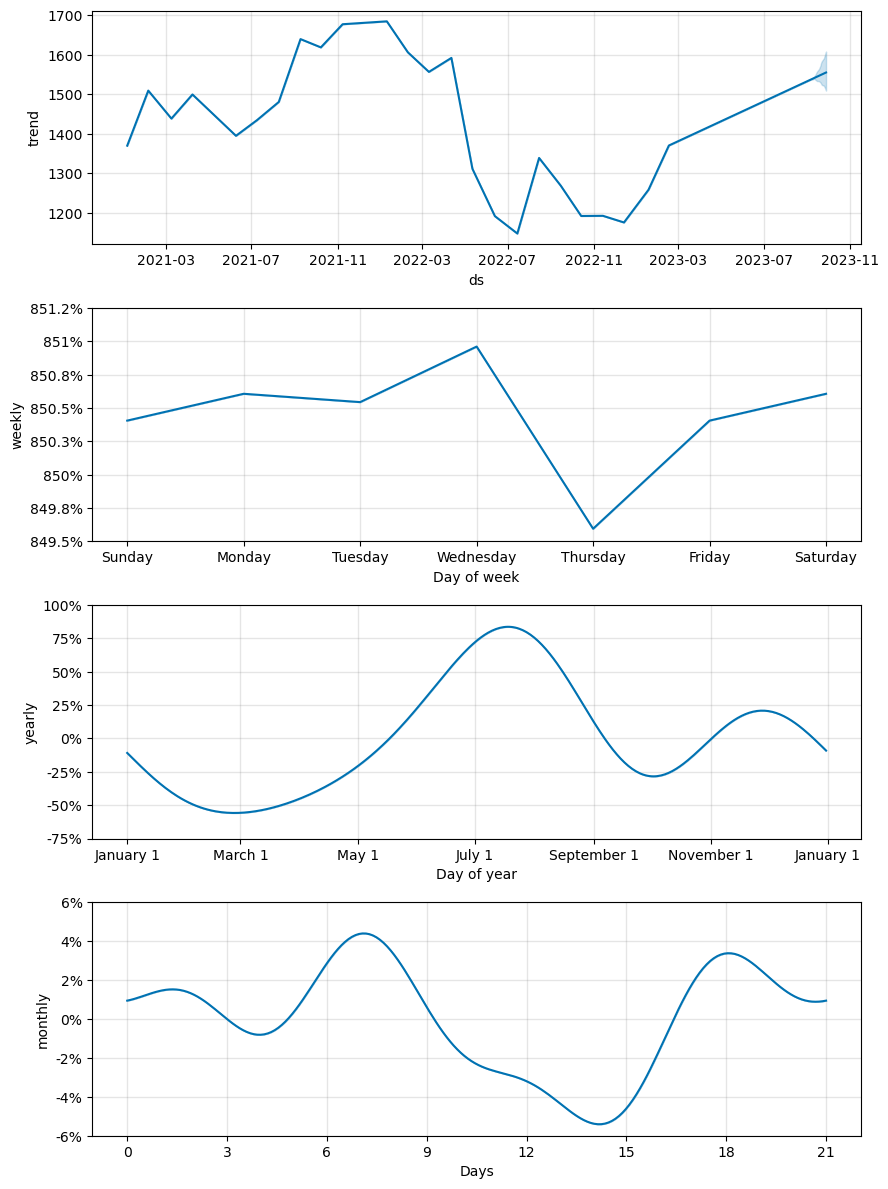

In [10]:
# Re-initialize the Prophet model with custom seasonality
# and Fourier terms (Model 3)
m3 = Prophet(seasonality_mode='multiplicative',
             daily_seasonality=False,
             weekly_seasonality=False,
             yearly_seasonality=4 
).add_seasonality(
    name='monthly',
    period=21,  
    fourier_order=4, 
    prior_scale=10
).add_seasonality(
    name='weekly',
    period=5,  
    fourier_order=5,  
    prior_scale=10
).fit(df_train)
future = m3.make_future_dataframe(periods=21, freq='B')
# Making and plotting predictions
forecast3 = m3.predict(future)
Prophet.plot(m3, forecast3)
# Components Visualization
m3.plot_components(forecast3)
# Print the last 2 forecast Components
print(forecast3.tail(2).transpose())

### Changepoints

In [11]:
# Suppress DEBUG and INFO messages specifically for the 'prophet' and 'cmdstanpy' loggers
import logging
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/P

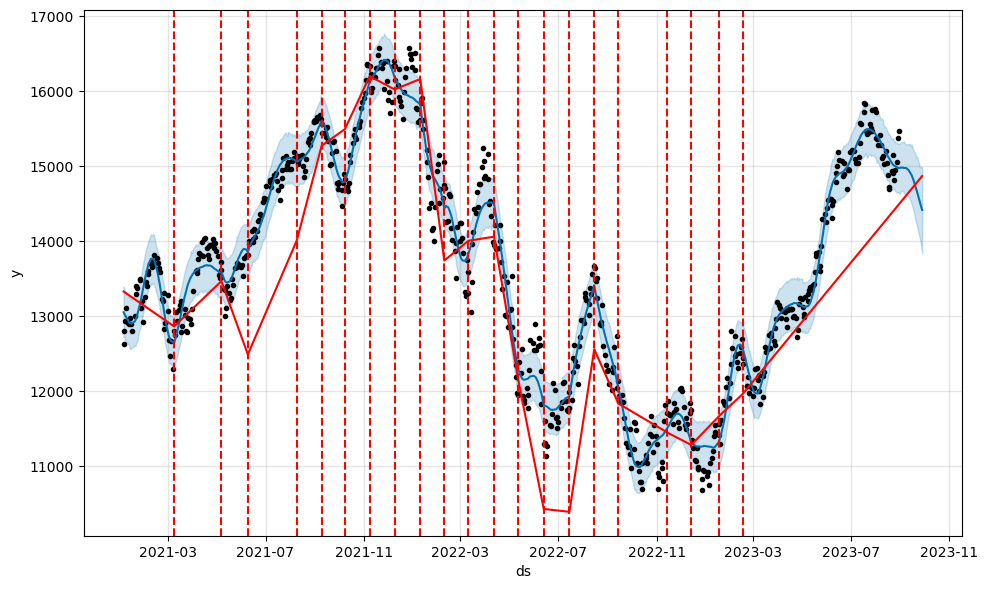

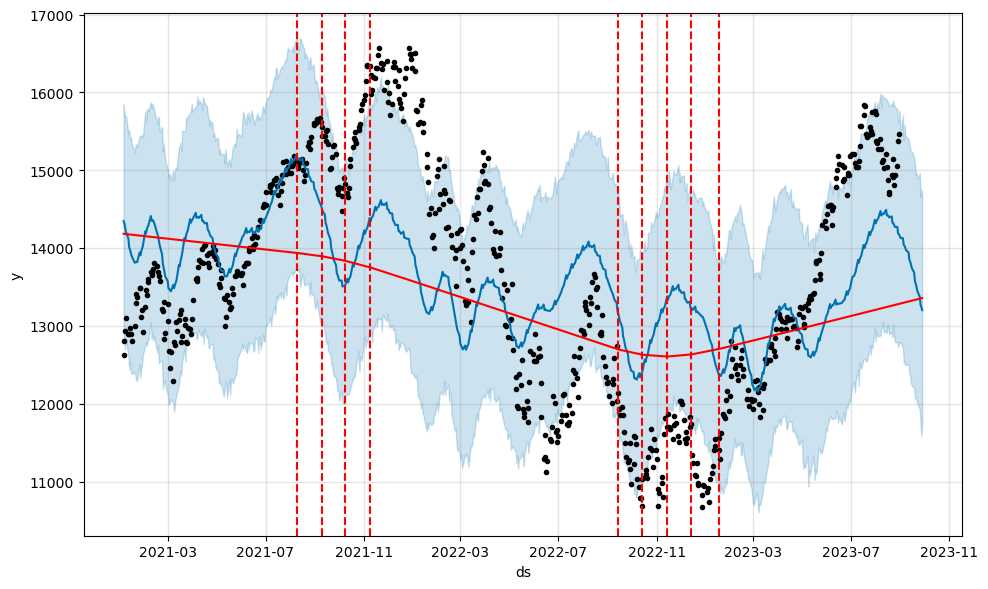

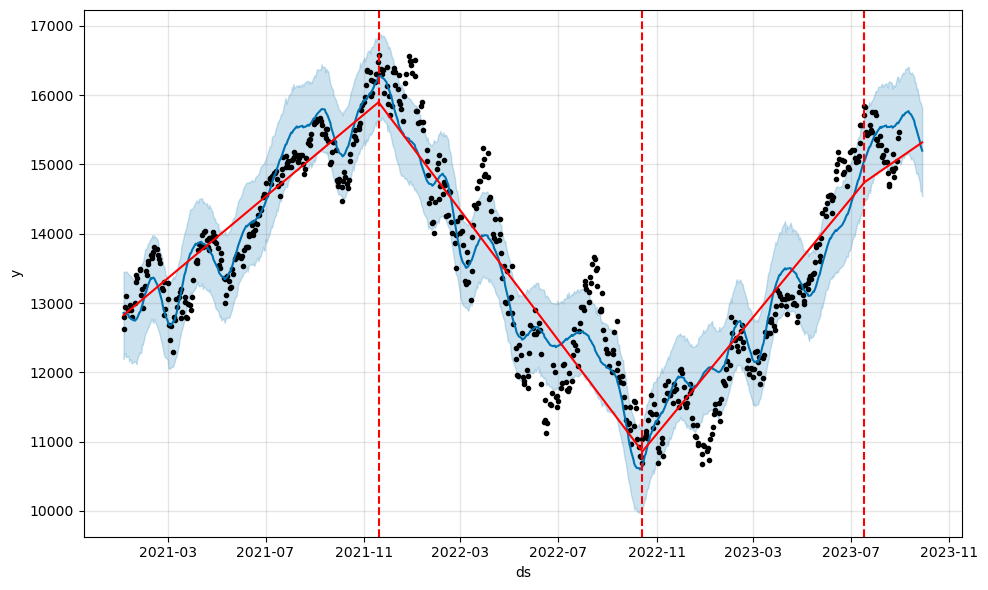

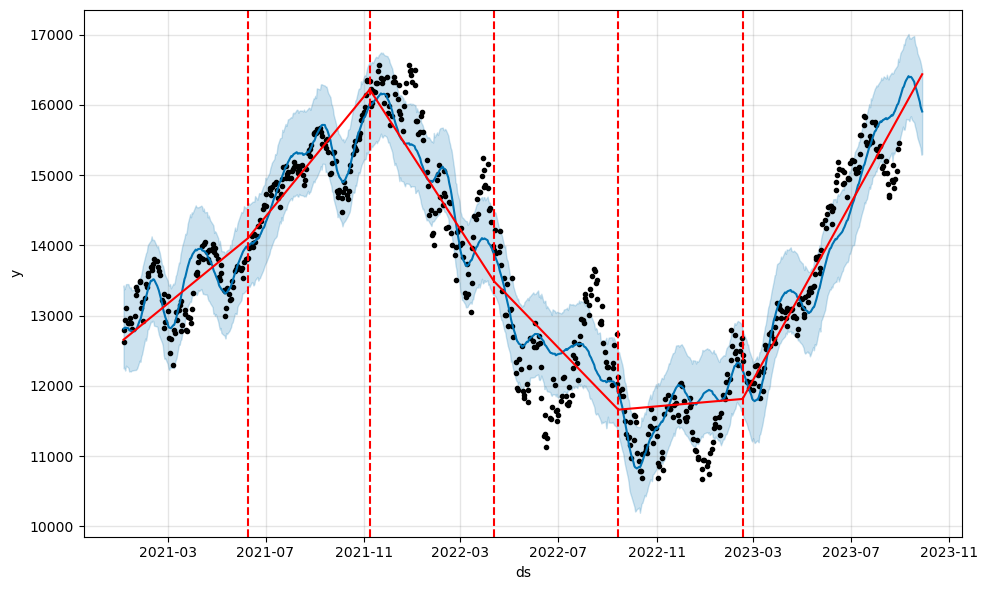

In [12]:
from prophet.plot import add_changepoints_to_plot
# Initialize Prophet with high sensitivity 
# to changepoints
m = Prophet(changepoint_prior_scale=0.9)
forecast = m.fit(df_train).predict(future)
# Plot forecast with changepoint_prior_scale=0.9
# (Figure 10.7)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# Initialize Prophet with low sensitivity 
# to changepoints
m = Prophet(changepoint_prior_scale=0.005)
forecast = m.fit(df_train).predict(future)
# Plot forecast with changepoint_prior_scale=0.005
# (Figure 10.8)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# Prophet with manual changepoints and 
# intermediate sensitivity
m = Prophet(
    changepoints=['2021-11-19', 
                  '2022-10-14', 
                  '2023-07-18']
)
forecast = m.fit(df_train).predict(future)
# Plot forecast with custom changepoints
# (Figure 10.9)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# Prophet specifying a fixed number of 
# changepoints without manual dates
m = Prophet(n_changepoints=5)
forecast = m.fit(df_train).predict(future)
# Plot forecast with n_changepoints=5
# (Figure 10.10)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Additional Regressors

MAPE for the test data: 1.13%


/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



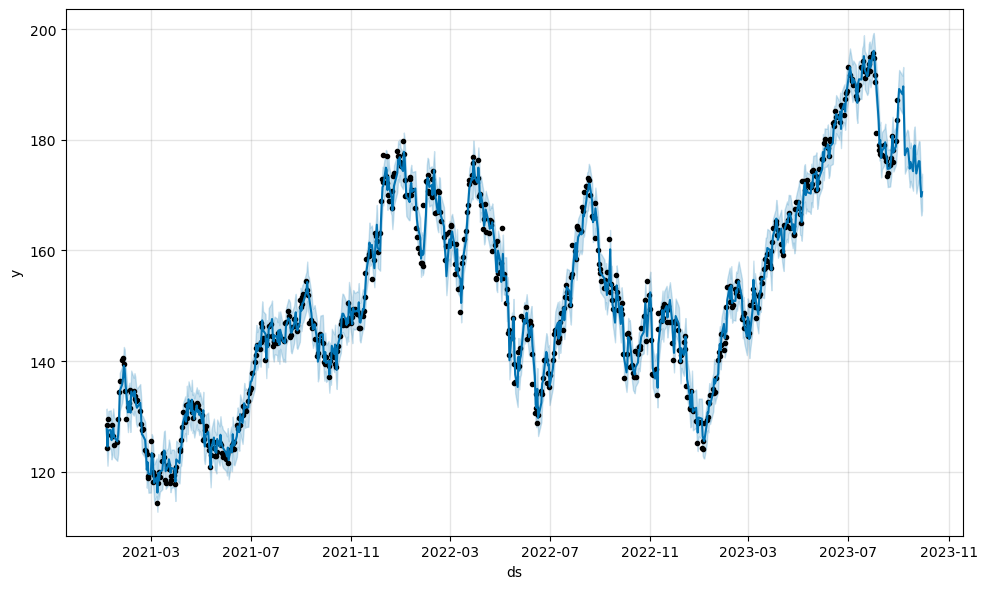

In [21]:
# Create the DataFrame for Prophet with lagged regressors
data = nasdaq_assets.xs('AAPL', level=1, axis=1)
df = pd.DataFrame({
    'ds': data.index,
    'y': data['Adj Close'],
    'High_lag1': data['High'].shift(1),
    'Low_lag1': data['Low'].shift(1),
    'tech1': (data['Close'].shift(1) > data['Open'].shift(1))
}).dropna()
# Split data into training and testing sets
test_period = 21
df_train = df[:-test_period]
df_test = df[-test_period:]
# Define special events - dividends payouts as special events
dividends_events = pd.DataFrame({
    'holiday': 'dividend_event',
    'ds': data[data['Dividends'] != 0].index,
    'lower_window': -1,  # Day before dividend payout
    'upper_window': 1,   # Day after dividend payout
})
# Initialize Prophet model with multiplicative seasonality
# and special events
m = Prophet(seasonality_mode='multiplicative',
            holidays=dividends_events)
# Add external regressors to the model
m.add_regressor('High_lag1')
m.add_regressor('Low_lag1')
m.add_regressor('tech1')
# Fit the model with training data
m.fit(df_train)
# Make predictions on both training and test datasets
forecast = m.predict(df)
# Plotting the forecast
Prophet.plot(m, forecast)
# Calculate and print the Mean Absolute Percentage Error (MAPE) on test data
mape = mean_absolute_percentage_error(df_test['y'], forecast['yhat'][-21:]) * 100
print(f"MAPE for the test data: {mape:.2f}%")

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



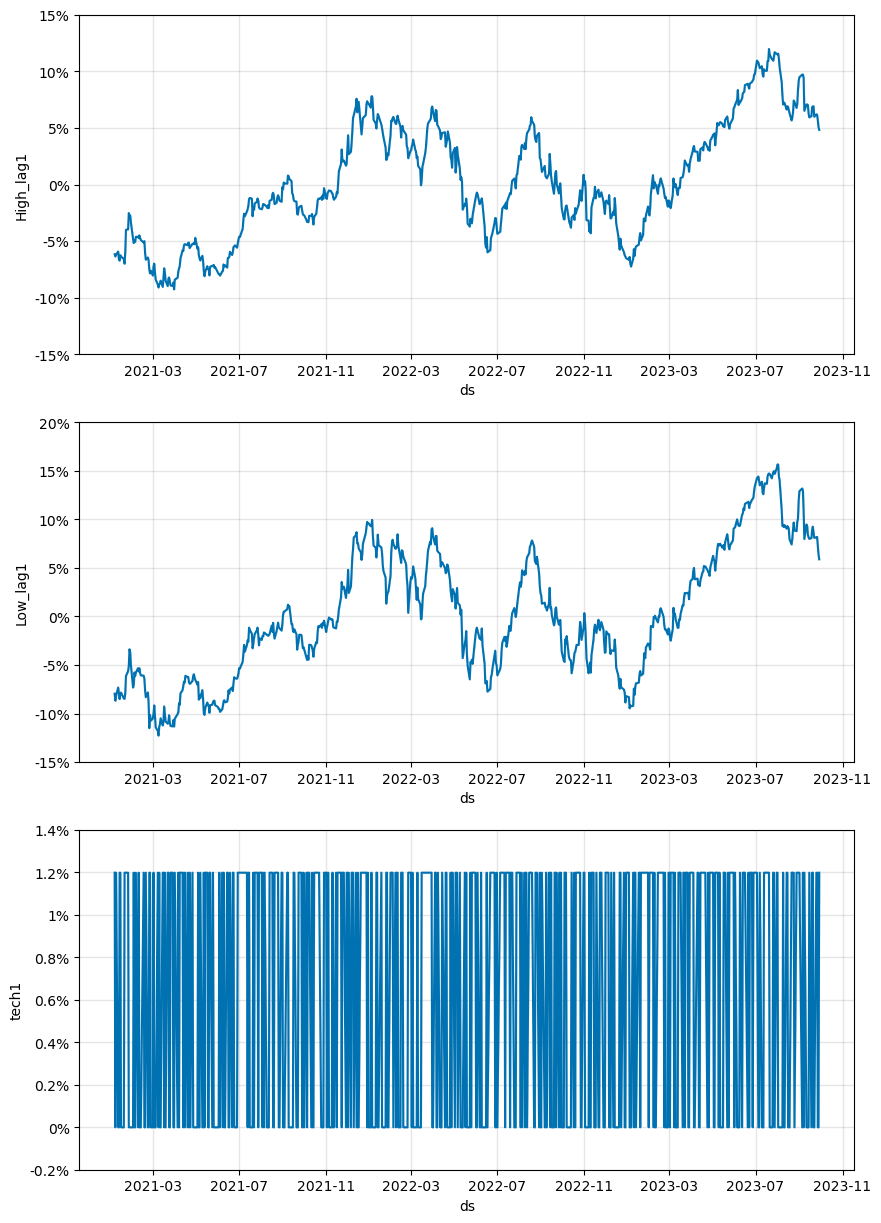

In [14]:
fig, axes = plt.subplots(len(regressor_coefficients(m)),
                         figsize=(10, 15))
for i, regressor in enumerate(
    regressor_coefficients(m)['regressor']):
    plot_forecast_component(m,
                            forecast,
                            regressor,
                            axes[i])

## Cross-validation and Hyperparameter tuning

In [15]:
# Suppress DEBUG and INFO messages specifically for the 'prophet' and 'cmdstanpy' loggers
import logging
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

  0%|          | 0/4 [00:00<?, ?it/s]

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  2.271056  1.507002  0.958291  0.014455  0.003739  0.014719   
1  2 days  3.790078  1.946812  1.526941  0.024452  0.023193  0.024374   
2  3 days  7.422492  2.724425  2.348240  0.036748  0.036590  0.036744   
3  4 days  5.927198  2.434584  2.332173  0.036073  0.035725  0.035933   
4  5 days  5.970388  2.443438  2.079578  0.031822  0.027852  0.032071   

   coverage  
0      1.00  
1      0.75  
2      0.50  
3      0.50  
4      0.50  


/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:544: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/prophet/plot.py:545: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



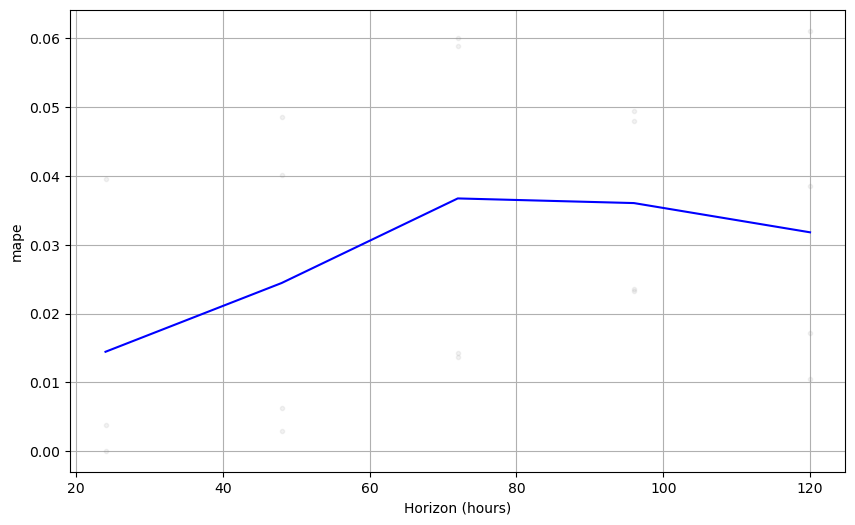

In [22]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
# Load the data into a DataFrame 'df'
data = nasdaq_assets.xs('AZN', level=1, axis=1)
df = pd.DataFrame({
    'ds': pd.to_datetime(data.index),
    'y': data['Adj Close']
})
test_period = 5
df_train = df[:-test_period]
df_test = df[-test_period:]
# Initialize and fit the Prophet model
m = Prophet()
m.fit(df_train)
# Perform cross-validation
df_cv = cross_validation(m, initial='504 days', 
                         period='126 days', horizon='5 days')
# Calculate performance metrics
df_p = performance_metrics(df_cv)
# Plot cross-validation metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
# Print Cross-Validation Table
print(df_p)

In [25]:
import itertools
# Load the data into a DataFrame 'df'
data = nasdaq_assets.xs('AZN', level=1, axis=1)
df = pd.DataFrame({
    'ds': pd.to_datetime(data.index),
    'y': data['Adj Close']
})
# Parameter grid for tuning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.5, 0.9],
    'seasonality_prior_scale': [0.01, 8.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in 
              itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params
# Use cross-validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_train)  
    df_cv = cross_validation(m, initial='504 days', 
                             period='126 days', horizon='5 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])  
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results.transpose())
best_params = all_params[np.argmin(mapes)]
print(best_params)
# Comparing the models
# Initialize and fit the basic Prophet model
m1 = Prophet().fit(df_train)
# Predict on the test dataset
forecast1 = m1.predict(df)
# Calculate MAPE on the test dataset for the basic model
mape1 = mean_absolute_percentage_error(forecast1['yhat'][-test_period:],
                                       df_test['y']) * 100
print(f"Basic model for test data: MAPE = {mape1:.2f}%")
# Initialize and Fit the Prophet model with custom tunned parameters
m2 = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
).fit(df_train)
# Predict on the test dataset with the tuned model
forecast2 = m2.predict(df)
# Calculate MAPE on the test dataset for the tuned model
mape2 = mean_absolute_percentage_error(forecast2['yhat'][-test_period:],
                                       df_test['y']) * 100
print(f"Tuned model for test data: MAPE = {mape2:.2f}%")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

                               0               1         2               3   \
changepoint_prior_scale      0.01            0.01      0.01            0.01   
seasonality_prior_scale      0.01            0.01       8.0             8.0   
seasonality_mode         additive  multiplicative  additive  multiplicative   
mape                     0.041357        0.040257  0.040865        0.040475   

                               4               5         6               7   \
changepoint_prior_scale      0.01            0.01       0.5             0.5   
seasonality_prior_scale      10.0            10.0      0.01            0.01   
seasonality_mode         additive  multiplicative  additive  multiplicative   
mape                     0.040392        0.040532  0.020104        0.019051   

                               8               9         10              11  \
changepoint_prior_scale       0.5             0.5       0.5             0.5   
seasonality_prior_scale       8.0             8.0 

In [20]:
plot_plotly(m2, forecast2)

# Chapter 10
## &copy; Dr. Dmytro Zherlitsyn, 2024 <br>
## &copy; BPB Publications, 2024